In [84]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import optimize


# WSL not working with jypyter notebook

import ase
from ase import Atoms
from ase.units import eV, Ang, GPa

import Morse

import sys
sys.path.append(r'files')
# set facecolor to white
plt.rcParams['figure.facecolor'] = 'white'

In [85]:
# This code was written by myself as I thought I was meant to write it myself
# However I am still unsure as code has been provided as an attached calculator for ASE

def interaction_potential(r, r0, alpha):
    dr = r - r0
    return np.exp(- 2 * alpha * dr) - 2 * np.exp( - alpha * dr)

def morse_potential(positions, r0, alpha, D ):
    # loop for each pair of atoms once
    for i in range(len(positions)):
        for j in range(i+1, len(positions)): # i never equals j
            r = np.linalg.norm(positions[i] - positions[j])
            if r < r0:
                return D * interaction_potential(r, r0, alpha)
    

The minimum energy is -0.16155999041418725 eV at a distance of 2.6164164164164165 Ang


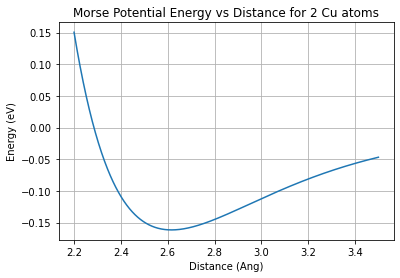

In [86]:

energies = []
distances = Ang*np.linspace(2.2, 3.5, 1000)

for d in distances:

    a = Atoms('2Cu', positions=[(0., 0., 0.), (0., 0., d)])
    calc = Morse.MorsePotential()
    a.set_calculator(calc)
    energies.append(a.get_potential_energy())

plt.plot(distances, energies)
plt.xlabel('Distance (Ang)')
plt.ylabel('Energy (eV)')
plt.title('Morse Potential Energy vs Distance for 2 Cu atoms')
plt.grid()

minimum_energy = min(energies)
minimum_distance = distances[energies.index(minimum_energy)]
print(f'The minimum energy is {minimum_energy} eV at a distance of {minimum_distance} Ang')

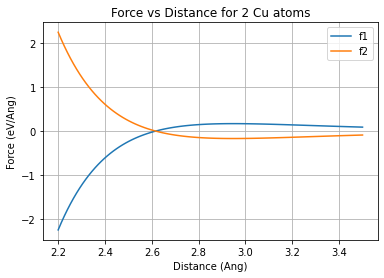

In [96]:
f1 = []
f2 = []
distances = Ang*np.linspace(2.2, 3.5, 100)

for d in distances:

    a = Atoms('2Cu', positions=[(0., 0., 0.), (0., 0., d)])
    calc = Morse.MorsePotential()
    a.set_calculator(calc)
    f1.append(a.get_forces()[0,2])
    f2.append(a.get_forces()[1,2])

plt.plot(distances, f1, label='f1')
plt.plot(distances, f2, label='f2')
plt.legend()
plt.title('Force vs Distance for 2 Cu atoms')
plt.xlabel('Distance (Ang)')
plt.ylabel('Force (eV/Ang)')
plt.grid()


In [97]:
# Write a unit test that verifies that the forces returned by the get_forces() function 
# is really the negative gradient of the energy (as returned by the get_potential_energy() function) 
# with respect to the atomic positions. Do this by comparing the forces returned by get_forces() to those 
# obtained by numerical finite differences of energies between two sets of atomic positions, displaced by small amount.

import unittest

class TestMorsePotential(unittest.TestCase):
    def test_get_forces(self):
        eta = 1e-10
        a1 = Atoms('2Cu', positions=[(0., 0., 0.), (0., 0., 1.5)])
        a2 = Atoms('2Cu', positions=[(0., 0., 0.), (0., 0., 1.5 + eta * Ang)])
        calc = Morse.MorsePotential()
        a1.set_calculator(calc)
        a2.set_calculator(calc)
        f1 = a1.get_forces()[0,2]
        e1 = a1.get_potential_energy()
        e2 = a2.get_potential_energy()
        f2 = (e2 - e1) / (eta * Ang)
        self.assertAlmostEqual(f1, f2, places=3)

# run the unit test
unittest.main(argv=[''], verbosity=2, exit=False)

test_get_forces (__main__.TestMorsePotential) ... C:\Users\louis\AppData\Roaming\Python\Python39\site-packages\ase\utils\__init__.py:62: DeprecationWarning: Please use atoms.calc = calc
  warnings.warn(warning)
ok

----------------------------------------------------------------------
Ran 1 test in 0.004s

OK


Through testing:

for small $\epsilon$ unit test fails (When $\epsilon < 1e-10$) as is not accurate within 3 places

For large $\epsilon$ unit test also fails (When $\epsilon > 1e-6$) as is again not accurate to within 3 places

As $\epsilon$ tends to zero so do $\nabla E$ and $f$ and so decimal places are lost in the differentiation calculation causing the unit test to fail

Task 3

C:\Users\louis\AppData\Roaming\Python\Python39\site-packages\ase\utils\__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)


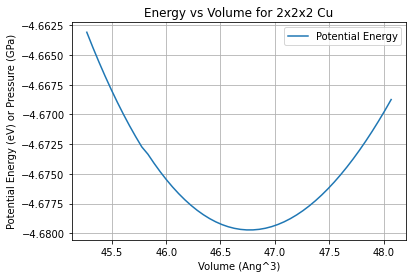

In [100]:
from ase.build import bulk#
from ase.units import eV, Ang, GPa, kJ

strains = np.linspace(-0.01, 0.01, 50)

vols = []
Ks = []
Ps = []
energies = []

for s in strains:

    cu = bulk("Cu", "fcc", a=3.6, cubic=True)

    calc = Morse.MorsePotential()
    cu.set_calculator(calc)
    cu222 = cu.copy()        # creating a copy of an Atoms object
    cu222.set_calculator(calc) # copying DOES NOT bring the attached calculator, so we need to set it again
    #cu222 *= (2,2,2)         # replicating the unit cell is accomplished by the multiplying operator

    # pre strain
    V1 = cu222.get_volume()
    P1 = - 1/3 * np.trace(cu222.get_stress(voigt=False))

    # applying strain
    cell = cu222.get_cell()
    cell *= (1 + s)
    cu222.set_cell(cell, scale_atoms=True) # To apply strain, the atomic positions need to be scaled together with the unit cell 
    cu222.get_cell()

    # post strain
    V2 = cu222.get_volume()
    P2 = - 1/3 * np.trace(cu222.get_stress(voigt=False))
    K = - V2 * (P2 - P1) / (V2 - V1)
    e = cu222.get_potential_energy()

    # converting to eV/Ang^3 to GPa
    K = K / kJ * 1e24
    # converting to eV/Ang^3 to GPa
    P = P2 / kJ * 1e24

    vols.append(V2)
    Ks.append(K)
    Ps.append(P)
    energies.append(e)

    #print(P)



plt.plot(vols, energies, label='Potential Energy') # plotting the bulk modulus as a function of the volume
plt.xlabel('Volume (Ang^3)')
plt.ylabel('Potential Energy (eV) or Pressure (GPa)')
plt.title('Energy vs Volume for 2x2x2 Cu')
plt.legend()
plt.grid()


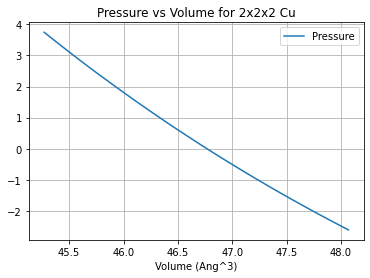

In [99]:
plt.plot(vols, Ps, label='Pressure') # plotting pressure  as a function of the 
plt.xlabel('Volume (Ang^3)')
plt.title('Pressure vs Volume for 2x2x2 Cu')
plt.legend()
plt.grid()



Correct range of Bulk Moduli

Minimum energy:  -4.679711427205635 eV
Volume at minimum energy:  46.74174717072402 Ang^3
Bulk modulus at minimum energy:  104.90521377447314 GPa


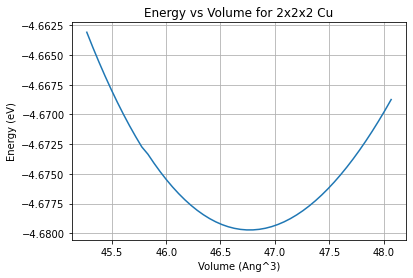

In [121]:
plt.plot(vols, energies)
plt.xlabel('Volume (Ang^3)')
plt.ylabel('Energy (eV)')
plt.title('Energy vs Volume for 2x2x2 Cu')
# print the minimum energy and the corresponding volume
print('Minimum energy: ', min(energies), 'eV')
v_min = vols[energies.index(min(energies))]
print('Volume at minimum energy: ', v_min, 'Ang^3')
print('Bulk modulus at minimum energy: ', Ks[energies.index(min(energies))], 'GPa')
equ_strain = strains[energies.index(min(energies))] / vols[0]

plt.grid()

Task 4 part 1

Write a program to compute the shear modulus.

In [119]:
L = 3.6
d_v_min = v_min**(1/3)
print(d_v_min)

cu = bulk("Cu", "fcc", a=d_v_min, cubic=True)
calc = Morse.MorsePotential()
cu.set_calculator(calc)
cu222 = cu.copy()        # creating a copy of an Atoms object
cu222.set_calculator(calc) # copying DOES NOT bring the attached calculator, so we need to set it again
cu222 *= (5,5,5)         # replicating the unit cell is accomplished by the multiplying operator

# apply shear strain
cell = cu222.get_cell()
cell[0,1] = 0.01 * d_v_min
cu222.set_cell(cell, scale_atoms=True)

S = cu222.get_stress(voigt=False)
print(S)

3.602204081632652
[[-3.72870361e-04  1.06914799e-03 -2.06051021e-19]
 [ 1.06914799e-03 -3.69283943e-04 -1.55577428e-19]
 [-2.06051021e-19 -1.55577428e-19 -3.63356924e-04]]


C:\Users\louis\AppData\Roaming\Python\Python39\site-packages\ase\utils\__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)


Observe which components of the stress matrix is nonzero, and think about which one you need to work out the shear modulus.

In [120]:
G = S[0,1] / 0.01
# converting to eV/Ang^3 to GPa
G = G / kJ * 1e24
print(G) # engineering shear modulus?
print(f"Shear modulus {G/2} GPa ?")

17.129639170281692
Shear modulus 8.564819585140846 GPa ?


Close! Actual shear modulus for copper is 44 GPa

Part 2 Write a program to determine the Poisson ratio

The Poisson ratio depends very sensitively on the starting volume, so make sure you use the unit cell size that corresponds to the lowest energy, accurate to at least 4 decimal places.

This is likely incorrect due to a very high initial stress which could be due to the volume calculation?

C:\Users\louis\AppData\Roaming\Python\Python39\site-packages\ase\utils\__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)


The poisson ratio of copper is: 0.36363636363636365


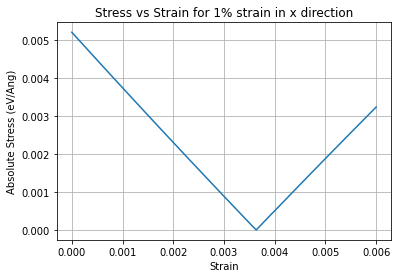

In [126]:
strains=np.linspace(0, 0.006, 100) #0-0.6%
basestrain=0.01 #1%
stresses = []

for s in strains:
    cu = bulk("Cu", "fcc", a=3.6036, cubic=True)
    cu.set_calculator(calc)
    cell=cu.get_cell()
    cell[0,0]*=(1-basestrain) # 1% strain in x direction
    cell[1,1]*=(1+s) # s% strain in y direction
    cell[2,2]*=(1+s) # s% strain in z direction
    cu.set_cell(cell, scale_atoms=True)
    stress = cu.get_stress(voigt=False)[1,1]
    stresses.append(abs(stress))

plt.plot(strains,stresses)
plt.xlabel("Strain")
plt.ylabel("Absolute Stress (eV/Ang)")
plt.title("Stress vs Strain for 1% strain in x direction")
min_stress_index=np.argmin(stresses)
nu = strains[min_stress_index] / basestrain
print(f"The poisson ratio of copper is: {nu}") # get minimum 
plt.grid()
plt.show()


Dislocations move diagonally until they reach a pin or obstruction or wall boundary at which they can deflect causing another dislocation which forms a small neck in the bottom plate

The notch grows wider and deeper as a large amount of plastic deformation occurs in the center, this creates a rough break in the material